# TUTORIAL
# Data assimilation of azhimuthal thermoacoustics: twin experiments 



In [27]:
import numpy as np
import os
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Create true data 
Create the reference truth and the observations.

*The code below can be compacted with the function ```create_truth```, which outputs a dictionary:*
```
  
from essentials.create import create_truth
truth = create_truth(model=Annular, manual_bias=manual_bias, **true_params)
```

In [28]:
from essentials.physical_models import Annular

ER = 0.5625
true_params = dict(nu=Annular.nu_from_ER(ER),
                   c2beta=Annular.c2beta_from_ER(ER),
                   std_obs=0.1,
                   noise_type='pink, add'
                   )
case = Annular(**true_params)

reference_params = case.alpha0

for reset in [1, 0, 0]:
    psi, t = case.time_integrate(int(case.t_transient / case.dt))
    if reset:
        case.update_history(psi[-1], reset=reset)
    else:
        case.update_history(psi, t, reset=reset)
        

Model dict_keys(['std_obs', 'noise_type']) not assigned


In [29]:
# Retrieve observables
y_true, t_true = case.get_observable_hist(), case.hist_t

# define the bias function
def manual_bias(yy, tt):
    bb = 0.2 * np.max(abs(yy))
    return bb, 'manual_offset_bias'

# Add bias to the reference data
b_true, name_bias = manual_bias(y_true, t_true)
y_true +=  b_true

# Add noise to the raw data
from  essentials.create import create_noisy_signal
y_raw = create_noisy_signal(y_true, noise_type=true_params['noise_type'], noise_level=true_params['std_obs'])


y_true, y_raw = [yy.squeeze() for yy in [y_true, y_raw]] 

In [30]:
# Select the observations time-window
t_start = Annular.t_transient 
t_stop = t_start + Annular.t_CR * 10
Nt_obs = 35

# Sample the observations
dt_t = t_true[1] - t_true[0]
obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)
y_obs, t_obs = [xx[obs_idx] for xx in [y_raw, t_true]]


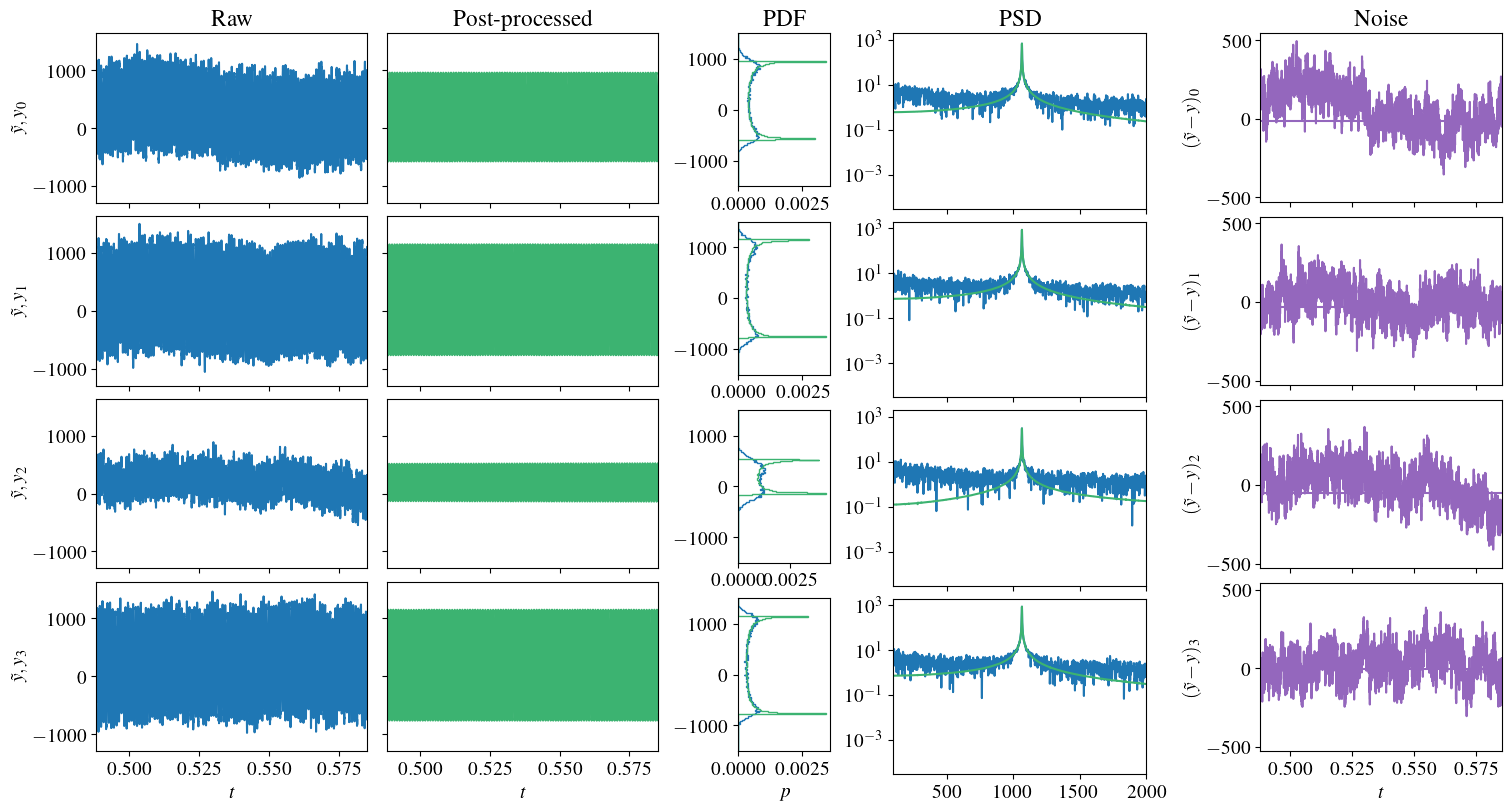

In [31]:
from essentials.plotResults import plot_truth

plot_truth(y_obs=y_obs, y_raw=y_raw, t=t_true, dt=dt_t, y_true=y_true, t_obs=t_obs)


## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble

*The code below can be compacted as*
```
from essentials.create import create_ensemble
ensemble = create_ensemble(model=Annular, **filter_params)
```

In [32]:
print(case.alpha0)
6848 / 2 / np.pi

{'omega': 6848.671984825749, 'nu': 25.105625000000032, 'c2beta': 37.02375000000002, 'kappa': 0.00012, 'epsilon': 0.0023, 'theta_b': 0.63, 'theta_e': 0.66}


1089.8930502932992

In [33]:
alpha0 = dict(nu=(20., 30.),
              c2beta=(30, 40),
              kappa=(1.E-4, 1.3E-4),
              epsilon=(0.001, 0.03),
              omega=(1085 * 2 * np.pi, 1100 * 2 * np.pi),
              theta_b=(0.5, 0.7),
              theta_e=(0.5, 0.8)
              )

alpha0_mean = dict()
for alpha, lims in alpha0.items():
    alpha0_mean[alpha] = 0.5 * (lims[0] + lims[1])

ensemble = Annular(**alpha0_mean)

filter_params = {'m': 10, 
                 'inflation': 1.001,
                 'std_psi': 0.3,
                 'std_a': alpha0}

# Forecast model to initialise the ensemble after transient
state, t_ = ensemble.time_integrate(int(ensemble.t_CR / ensemble.dt))
ensemble.update_history(state[-1], reset=True)

ensemble.init_ensemble(**filter_params)

ensemble_no_bias = ensemble.copy()



Visualize ensemble initialization

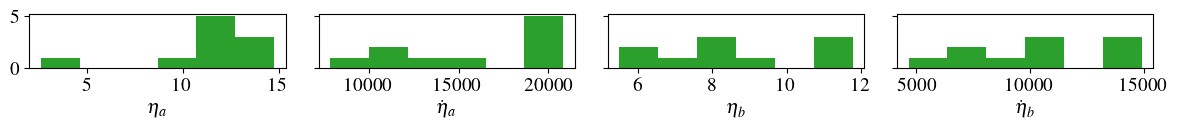

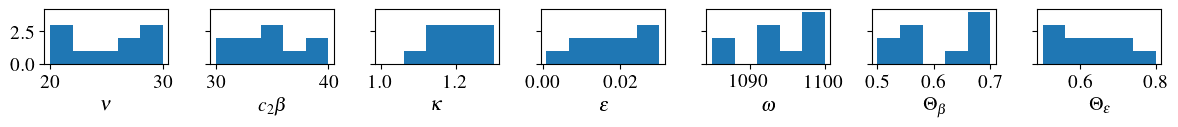

In [34]:
from essentials.plotResults import plot_ensemble
plot_ensemble(ensemble, reference_params={'kappa': 1e-4, 'omega': 2 * np.pi})

## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

<br><br>
**4.1. Initialise the ESN**

In [35]:
from essentials.bias_models import ESN
from essentials.create import create_bias_training_dataset


train_params = dict(bias_model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=10,
                    t_train=ensemble.t_CR * 20,
                    t_val=ensemble.t_CR * 5,
                    # Training data generation options
                    augment_data=True,
                    L=10,
                    noise=0.01, 
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.1),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-16]
                    )
ensemble.init_bias(**train_params)



**4.2. Create training data**

The details of the code inside ```create_bias_training_dataset()``` function is explained in the tutorial ```Class_Bias.ipynb```.

In [36]:
train_data = create_bias_training_dataset(y_raw, y_true, ensemble, **train_params)

Rerun multi-parameter training data: Increase the length of the training data



**4.3. Train the ESN**

The training convergence, hyperparameter optimization and testing results are saved in a pdf file in *figs_ESN* folder.

observed_idx [0 1 2 3] -> [0 1 2 3]
t_train 0.2 -> 0.2
t_val 0.05 -> 0.05
augment_data True -> True
bayesian_update False -> False
biased_observations False -> False
L 10 -> 10

 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-05	 1.000e-16	 -4.7752
2	 5.000e-01	 1.000e-03	 1.000e-16	 -4.3439
3	 5.000e-01	 1.000e-01	 1.000e-16	 -4.8002
4	 5.000e-01	 1.000e+01	 1.000e-16	 -3.6317
5	 7.000e-01	 1.000e-05	 1.000e-16	 -4.8440
6	 7.000e-01	 1.000e-03	 1.000e-16	 -4.4741
7	 7.000e-01	 1.000e-01	 1.000e-16	 -4.4362
8	 7.000e-01	 1.000e+01	 1.000e-16	 -3.2792
9	 9.000e-01	 1.000e-05	 1.000e-16	 -5.0779
10	 9.000e-01	 1.000e-03	 1.000e-16	 -4.7711
11	 9.000e-01	 1.000e-01	 1.000e-16	 -3.0393
12	 9.000e-01	 1.000e+01	 1.000e-16	 -3.2615
13	 1.100e+00	 1.000e-05	 1.000e-16	 0.5725
14	 1.100e+00	 1.000e-03	 1.000e-16	 2.2686
15	 1.100e+00	 1.000e-01	 1.000e-16	 0.5293
16	 1.100e+00	 1

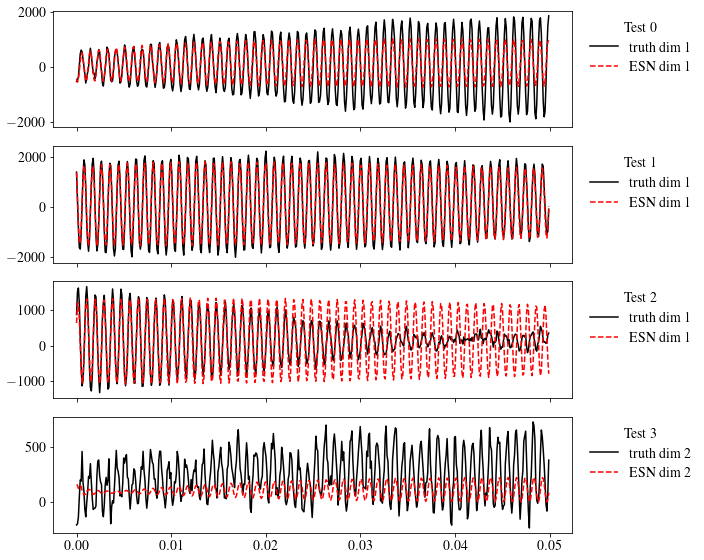

In [37]:
ensemble.bias.train_bias_model(**train_data)

**4.4. Create washout data**

We retrieve from the raw data a ```N_wash``` number of observations to use for initialising the ESN, i.e., to perform the washout. 
The ESN initialization must be before the fist observation.

In [38]:
ensemble.bias.t_init = t_obs[0] - 2 * Nt_obs * dt_t

i1 = np.argmin(abs(ensemble.bias.t_init - t_true))
i0 = i1 - ensemble.bias.N_wash  * ensemble.bias.upsample 

wash_obs = y_raw[i0:i1 + 1:ensemble.bias.upsample]
wash_t = t_true[i0:i1 + 1:ensemble.bias.upsample]

## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [39]:
ensemble_ESN = ensemble.copy()


In [41]:
# from essentials.DA import dataAssimilation

std_obs = true_params['std_obs']

DA_kwargs = dict(y_obs=y_obs.squeeze(), t_obs=t_obs, std_obs=std_obs, wash_obs=wash_obs, wash_t=wash_t)

ensemble_ESN.filter = 'rBA_EnKF'
ensemble_ESN.regularization_factor = 1.
ensemble_no_bias.filter ='EnSRKF'


out = []
for ens in [ensemble_no_bias, ensemble_ESN]:
    ens = ens.copy()
    ens.t_init = t_obs[0]
    ens.inflation = 1.01
    
    filter_ens = dataAssimilation(ens, **DA_kwargs.copy())
    
    #Forecast the ensemble further without assimilation
    Nt_extra = int(filter_ens.t_CR / filter_ens.dt)
    
    psi, t = filter_ens.time_integrate(Nt_extra)
    filter_ens.update_history(psi, t)
    
    y = filter_ens.get_observable_hist(Nt_extra)
    b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
    filter_ens.bias.update_history(b, t_b)
    
    out.append(filter_ens)



 ------------------ Annular Model Parameters ------------------ 
	 ER = 0.5
	 Nq = 4
	 c2beta = 35.0
	 dt = 1.95313e-05
	 epsilon = 0.0155
	 kappa = 0.000115
	 n = 1.0
	 nu = 25.0
	 omega = 6864.38
	 theta_b = 0.6
	 theta_e = 0.65

 ----------------  Bias model parameters ----------------  
 Bias model: NoBias

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = EnSRKF  
	 bias = NoBias 
 	 m = 10 
 	 Time steps between analysis = None 
 	 Inferred params = ['nu', 'c2beta', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.01 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'nu': (20.0, 30.0), 'c2beta': (30, 40), 'kappa': (0.0001, 0.00013), 'epsilon': (0.001, 0.03), 'omega': (6817.256058289851, 6911.503837897545), 'theta_b': (0.5, 0.7), 'theta_e': (0.5, 0.8)}
 	 Number of analysis steps = 143, t0=0.488262, t1=0.585332
 --------------------------------------------
Elapsed time to first observation: 1.367265224456787 s
Assimilation p

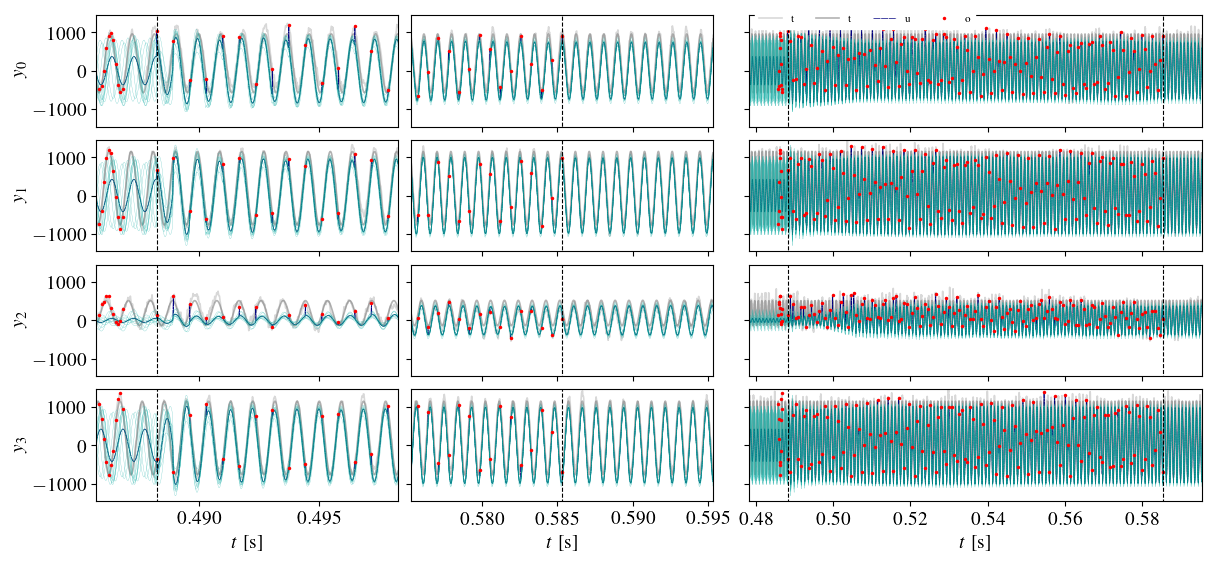

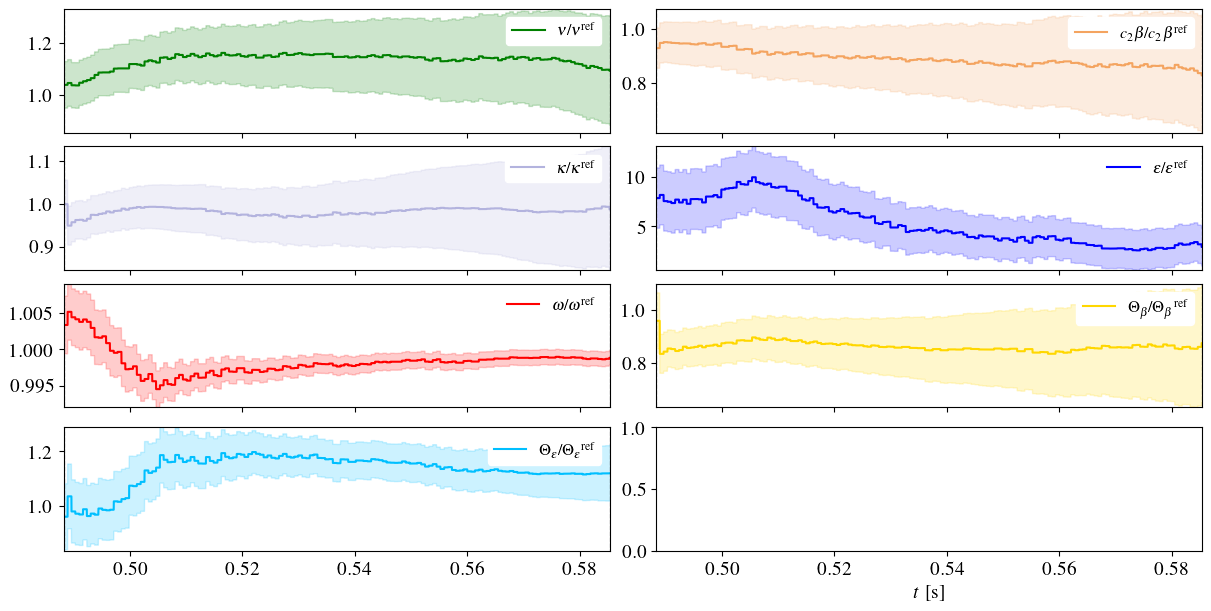

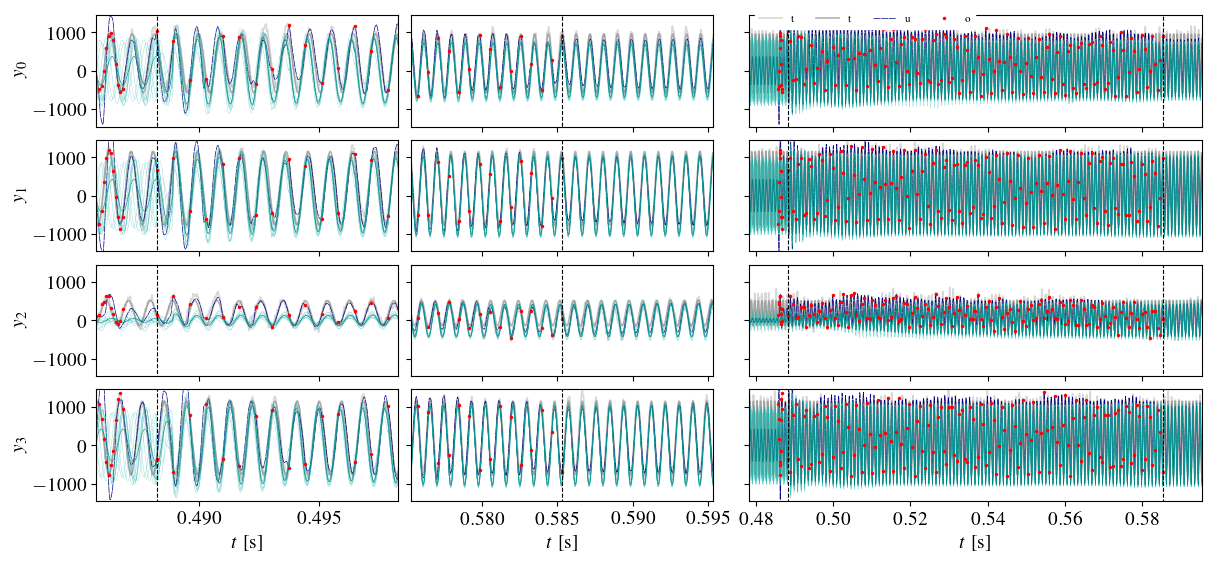

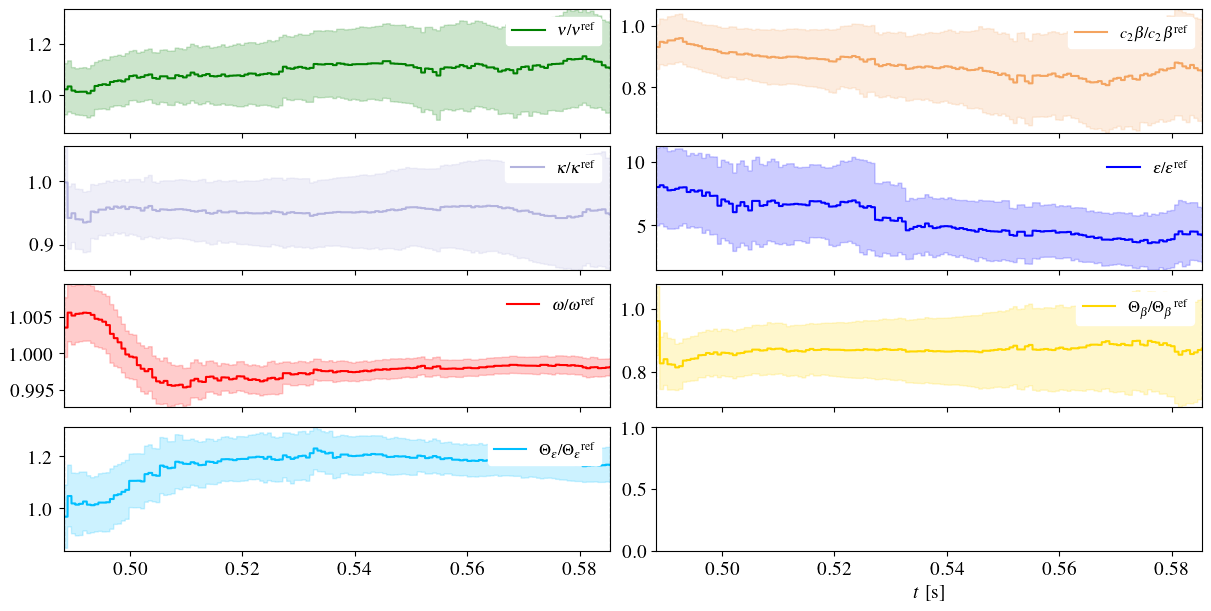

In [42]:
from essentials.plotResults import plot_timeseries, plot_parameters


truth = dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t,
             t_obs=t_obs, y_obs=y_obs, dt_obs=Nt_obs * dt_t,
             std_obs=std_obs, wash_t=wash_t, wash_obs=wash_obs)

for filter_ens in out:
    plot_timeseries(filter_ens, truth)
    plot_parameters(filter_ens, truth, reference_p=case.alpha0)

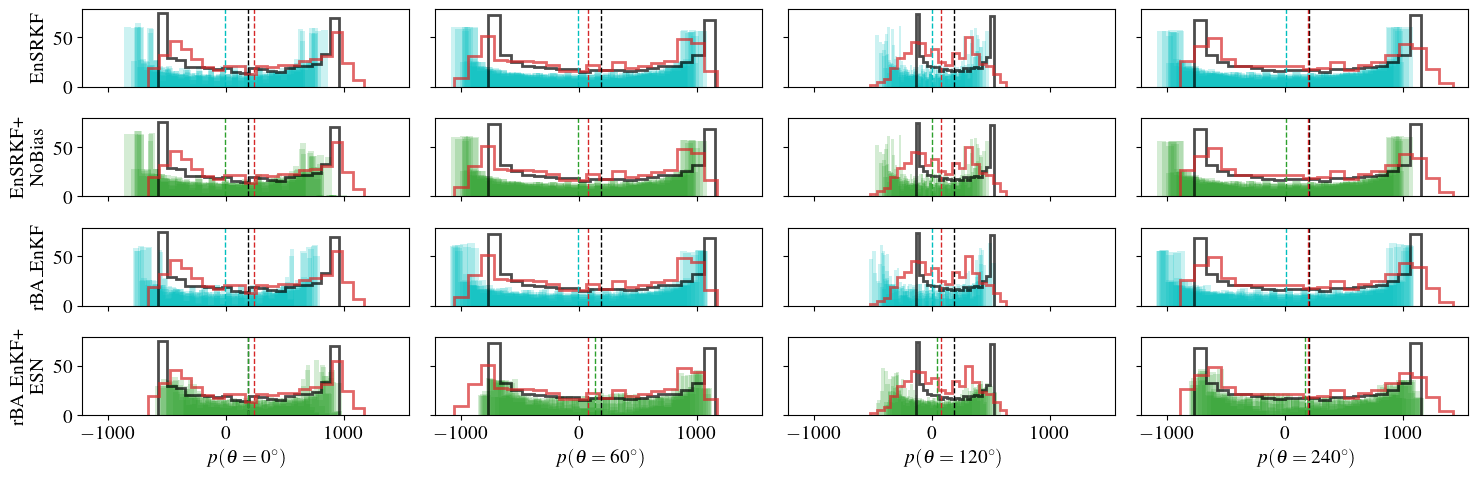

In [53]:
from essentials.plotResults import plot_states_PDF, plot_RMS_pdf
plot_states_PDF(out, truth)
plot_RMS_pdf(out, truth)


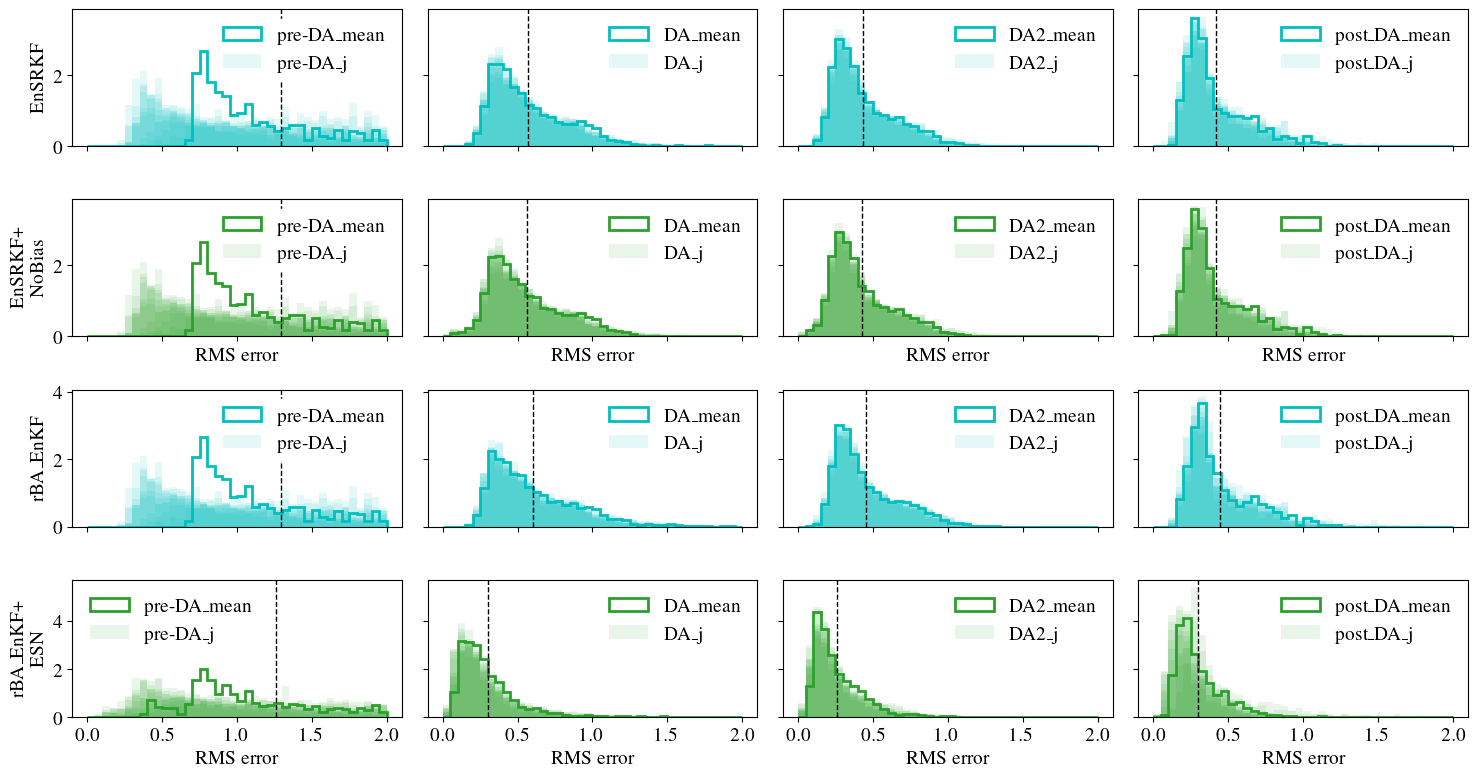